In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

# Agenda

- Introduction
- Strong convergence vs Weak convergence
- Euler-Maruyama and Milstein Method
- Runge-Kutta Methods
- Verlet Algorithm
- Exact Algorithm by Beskos et al.

# Introduction

- We want to simulate the solutions for an SDE (either paths, or distribution properties at specific timepoints).
- We want to understand the convergence properties of the solution.

# Convergence

### Strong convergence

The strong order of convergence is defined to be the largest exponent $\gamma$ such that if we numerically solve and SDE using $M = 1 / \Delta t$ steps of size $\Delta t$, then there exists a constant $K$ such that 
$$
\mathrm{E}[\vert \mathbf{x}(t_M) - \mathbf{\hat{x}}(t_M)\vert] \leq K \Delta t^{\gamma}
$$

### Weak convergence

The weak order of convergence is the largest exponent $\alpha$ such that 
$$
\left|\mathrm{E}\left[g\left(\mathbf{x}\left(t_{M}\right)\right)\right]-\mathrm{E}\left[g\left(\hat{\mathbf{x}}\left(t_{M}\right)\right)\right]\right| \leq K \Delta t^{\alpha},
$$
for any polynomial $g$. Note that for for the weak convergence we only need to approximate the distribution.

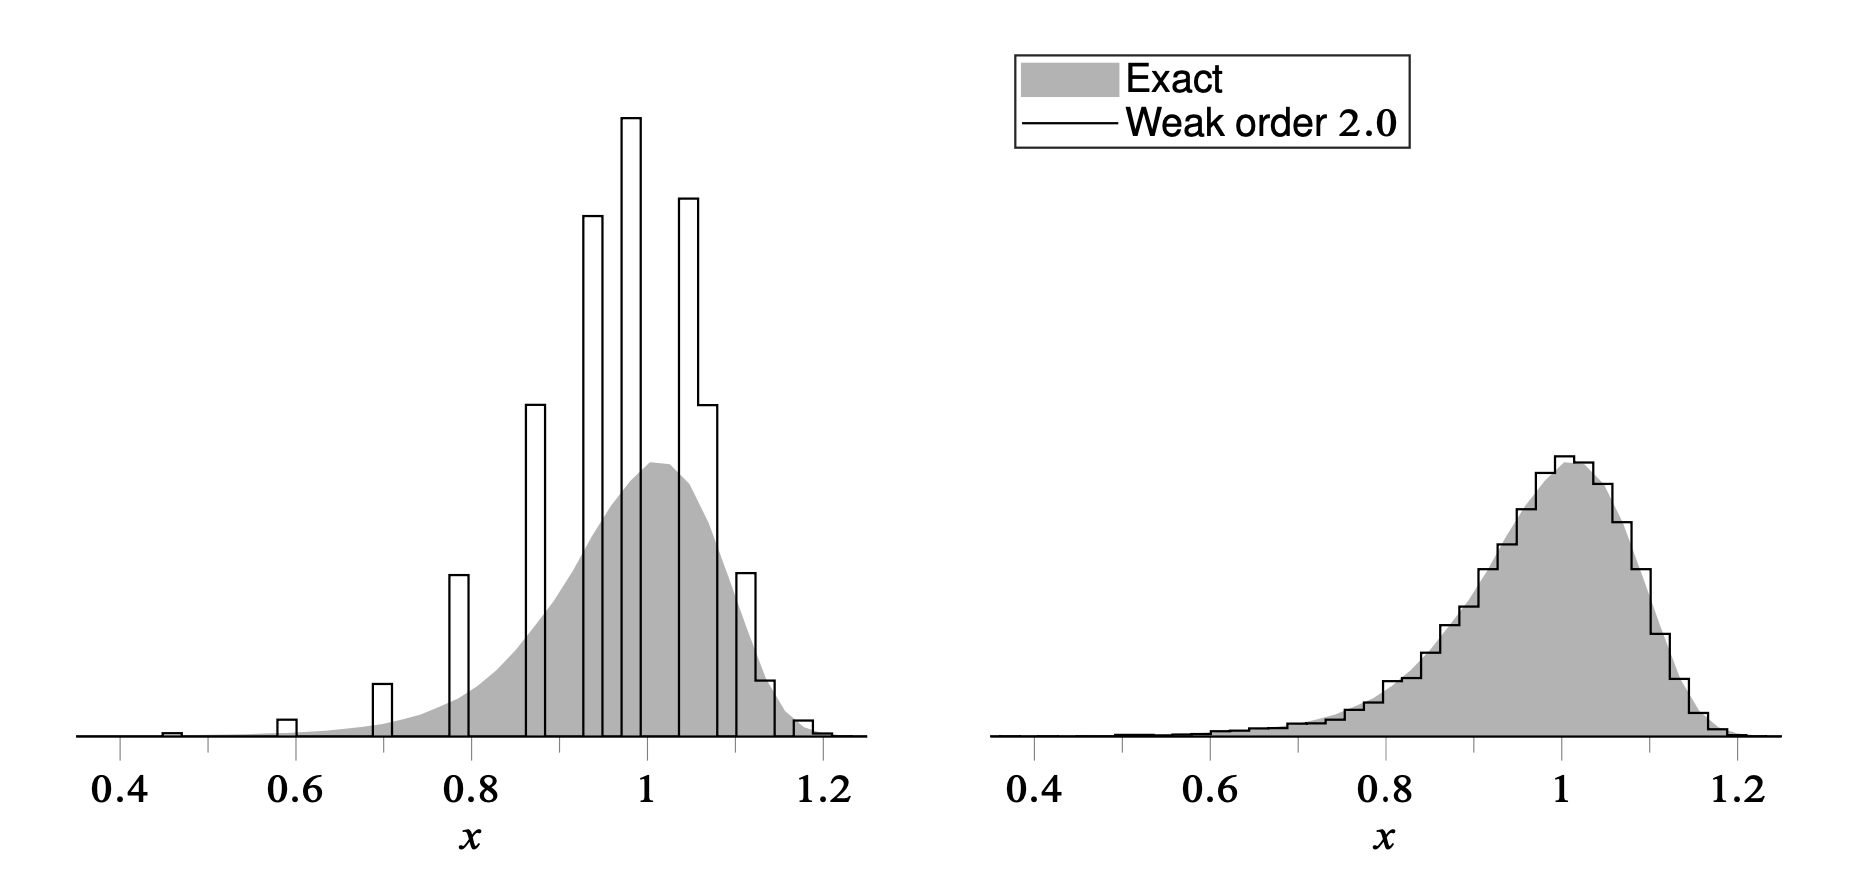

Under the _weak convergence_ criterion, the two solutions would have very similar error.

# Euler-Maruyama and Milstein methods

## ODE derivations

For an ODE of this form

$$
\frac{\mathrm{d} \mathbf{x}(t)}{\mathrm{d} t}=\mathbf{f}(\mathbf{x}(t), t), \quad \mathbf{x}\left(t_{0}\right)=\mathbf{x}_{0},
$$
the integral form reads 
$$
\begin{equation}
\mathbf{x}(t)=\mathbf{x}\left(t_{0}\right)+\int_{t_{0}}^{t} \mathbf{f}(\mathbf{x}(\tau), \tau) \mathrm{d} \tau \label{eq:ode-integral}
\end{equation}
$$

If the function $\mathbf{f}$ is differentiable we can write it as the solution to the following ODE:

$$
\frac{\mathrm{df}(\mathbf{x}(t), t)}{\mathrm{d} t}=\frac{\partial}{\partial t} \mathbf{f}(\mathbf{x}(t), t)+\sum_{i} f_{i}(\mathbf{x}(t), t) \frac{\partial}{\partial x_{i}} \mathbf{f}(\mathbf{x}(t), t)
$$

with $\mathbf{f}(\mathbf{x}(t_0), t_0)$ as the initial condition. The integral form of this ODE is:

$$
\begin{array}{l}
\mathbf{f}(\mathbf{x}(t), t)=\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \\
\quad+\int_{t_{0}}^{t}\left[\frac{\partial}{\partial t} \mathbf{f}(\mathbf{x}(\tau), \tau)+\sum_{i} f_{i}(\mathbf{x}(\tau), \tau) \frac{\partial}{\partial x_{i}} \mathbf{f}(\mathbf{x}(\tau), \tau)\right] \mathrm{d} \tau,
\end{array}
$$

which can be neatly written as 
$$
\mathbf{f}(\mathbf{x}(t), t)=\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)+\int_{t_{0}}^{t} \mathscr{L} \mathbf{f}(\mathbf{x}(\tau), \tau) \mathrm{d} \tau,
$$

where

$$
\mathscr{L}(\bullet)=\frac{\partial}{\partial t}(\bullet)+\sum_{i} f_{i} \frac{\partial}{\partial x_{i}}(\bullet)
$$

Substituting into $\eqref{eq:ode-integral}$, we obtain
$$
\begin{aligned}
\mathbf{x}(t) &=\mathbf{x}\left(t_{0}\right)+\int_{t_{0}}^{t}\left[\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)+\int_{t_{0}}^{\tau} \mathscr{L} \mathbf{f}\left(\mathbf{x}\left(\tau^{\prime}\right), \tau^{\prime}\right) \mathrm{d} \tau^{\prime}\right] \mathrm{d} \tau \\
&=\mathbf{x}\left(t_{0}\right)+\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(t-t_{0}\right)+\int_{t_{0}}^{t} \int_{t_{0}}^{\tau} \mathscr{L} \mathbf{f}\left(\mathbf{x}\left(\tau^{\prime}\right), \tau^{\prime}\right) \mathrm{d} \tau^{\prime} \mathrm{d} \tau
\end{aligned}
$$

Repearing the process $n$ times we obtain:
$$
\begin{array}{l}
\mathbf{x}(t) & =\mathbf{x}\left(t_{0}\right)+\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(t-t_{0}\right)+\frac{1}{2 !} \mathscr{L} \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(t-t_{0}\right)^{2} \\
& \quad+\frac{1}{3 !} \mathscr{L}^{2} \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(t-t_{0}\right)^{3}+\cdots
\end{array}
$$

$$
\mathbf{r}_{n}(t)=\int_{t_{0}}^{t} \cdots \int_{t_{0}}^{\tau} \mathscr{L}^{n} \mathbf{f}(\mathbf{x}(\tau), \tau) \mathrm{d} \tau^{n+1}
$$

## SDE Derivations

For an SDE of the integral form
$$
\begin{equation}
\mathbf{x}(t)=\mathbf{x}\left(t_{0}\right)+\int_{t_{0}}^{t} \mathbf{f}(\mathbf{x}(\tau), \tau) \mathrm{d} \tau+\int_{t_{0}}^{t} \mathbf{L}(\mathbf{x}(\tau), \tau) \mathrm{d} \beta(\tau),
\label{eq:sde-integral}
\end{equation}
$$

we can analogously compute Ito differentials of $\mathbf{f}(\mathbf{x}(\tau), \tau)$ and $\mathbf{L}(\mathbf{x}(\tau), \tau)$, obtain their integral form, and substitute back into $\eqref{eq:sde-integral}$

$$
\begin{array}{l}
\mathbf{x}(t)=\mathbf{x}\left(t_{0}\right)+\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(t-t_{0}\right)+\mathbf{L}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(\beta(t)-\beta\left(t_{0}\right)\right) \\
\quad+\int_{t_{0}}^{t} \int_{t_{0}}^{\tau} \mathscr{L}_{t} \mathbf{f}(\mathbf{x}(\tau), \tau) \mathrm{d} \tau \mathrm{d} \tau+\sum_{j} \int_{t_{0}}^{t} \int_{t_{0}}^{\tau} \mathscr{L}_{\beta, j} \mathbf{f}(\mathbf{x}(\tau), \tau) \mathrm{d} \beta_{j}(\tau) \mathrm{d} \tau \\
\quad+\int_{t_{0}}^{t} \int_{t_{0}}^{\tau} \mathscr{L}_{t} \mathbf{L}(\mathbf{x}(\tau), \tau) \mathrm{d} \tau \mathrm{d} \beta(\tau) \\
\quad+\sum_{j} \int_{t_{0}}^{t} \int_{t_{0}}^{\tau} \mathscr{L}_{\beta, j} \mathbf{L}(\mathbf{x}(\tau), \tau) \mathrm{d} \beta_{j}(\tau) \mathrm{d} \mathbf{\beta}(\tau)
\end{array}
$$

This is the basis for most of the methods we mention.

$$
\begin{aligned}
\mathscr{L}_{t}(\bullet) &=\frac{\partial(\bullet)}{\partial t}+\sum_{i} \frac{\partial(\bullet)}{\partial x_{i}} f_{i}+\frac{1}{2} \sum_{i, j} \frac{\partial^{2}(\bullet)}{\partial x_{i} \partial x_{j}}\left[\mathbf{L} \mathbf{Q} \mathbf{L}^{\top}\right]_{i j} \\
\mathscr{L}_{\beta, j}(\bullet) &=\sum_{i} \frac{\partial(\bullet)}{\partial x_{i}} L_{i j}, \quad \text { for } j=1,2, \ldots, S
\end{aligned}
$$

## Euler-Maruyama

From the previous derivation, simply take
$$
\mathbf{x}(t)=\mathbf{x}\left(t_{0}\right)+\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(t-t_{0}\right)+\mathbf{L}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(\beta(t)-\beta\left(t_{0}\right)\right),
$$

resulting in the following update rule (starting at $\hat{\mathbf{x}}(t_0) \sim p(\mathbf{x}(t_0))$:
1. Draw the Brownian motion increments as
$$\Delta \beta_k \sim \mathrm{N}(\mathbf{0}, \mathbf{Q} \Delta t).$$
2. Compute: 
$$ \hat{\mathbf{x}}\left(t_{k+1}\right)=\hat{\mathbf{x}}\left(t_{k}\right)+\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right), t_{k}\right) \Delta t+\mathbf{L}\left(\hat{\mathbf{x}}\left(t_{k}\right), t_{k}\right) \Delta \boldsymbol{\beta}_{k}.
$$

Strong order: 0.5, weak order 1

## Milstein Method


But we ignored a term of order $\mathrm{d}t^{1/2}$. Namely $\mathrm{d} \beta_{j}(\tau) \mathrm{d} \mathbf{\beta}(\tau)$ if of order $\mathrm{d}t^{1/2}$ when integrated as above.

Further expansion of the term 
$$
\sum_{j} \int_{t_{0}}^{t} \int_{t_{0}}^{\tau} \mathscr{L}_{\beta, j} \mathbf{L}(\mathbf{x}(\tau), \tau) \mathrm{d} \beta_{j}(\tau) \mathrm{d} \mathbf{\beta}(\tau)
$$

yields
$$
\begin{aligned}
\mathbf{x}(t)=& \mathbf{x}\left(t_{0}\right)+\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(t-t_{0}\right)+\mathbf{L}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\left(\boldsymbol{\beta}(t)-\boldsymbol{\beta}\left(t_{0}\right)\right) \\
&+\sum_{j} \mathscr{L}_{\beta, j} \mathbf{L}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \int_{t_{0}}^{t} \int_{t_{0}}^{\tau} \mathrm{d} \beta_{j}(\tau) \mathrm{d} \boldsymbol{\beta}(\tau)+\text { remainder. }
\end{aligned}
$$

This approximation gives us the *Milstein* discretisation scheme


1.Jointly draw a Brownian motion increment and the iterated Ito integral of it
$$
\begin{aligned}
\Delta \boldsymbol{\beta}_{k} &=\boldsymbol{\beta}\left(t_{k+1}\right)-\boldsymbol{\beta}\left(t_{k}\right) \\
\Delta \boldsymbol{\chi}_{v, k} &=\int_{t_{k}}^{t_{k+1}} \int_{t_{k}}^{\tau} \mathrm{d} \beta_{j}(\tau) \mathrm{d} \boldsymbol{\beta}(\tau)
\end{aligned}
$$
2. Compute
$$
\begin{aligned}
\hat{\mathbf{x}}\left(t_{k+1}\right)=& \hat{\mathbf{x}}\left(t_{k}\right)+\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right), t_{k}\right) \Delta t+\mathbf{L}\left(\hat{\mathbf{x}}\left(t_{k}\right), t_{k}\right) \Delta \boldsymbol{\beta}_{k} \\
&+\sum_{j}\left[\sum_{i} \frac{\partial \mathbf{L}}{\partial x_{i}}\left(\hat{\mathbf{x}}\left(t_{k}\right), t_{k}\right) \mathbf{L}_{i, j}\left(\hat{\mathbf{x}}\left(t_{k}\right), t_{k}\right)\right] \Delta \chi_{v, k}
\end{aligned}
$$

Strong order: 1, weak order: 1

### A few notes
1. Drawing the iterated stochastic integral jointly with the Brownian motion is hard.
2. We require the partial derivative of the $\mathbf{L}$ with respect to each component of $\mathbf{x}$
3. If the noise is additive , i.e. $\mathbf{L}(\mathbf{x}, t)=\mathbf{L}(t)$, the Milstein method reduces to the Euler-Maruyama method.
4. A special case is when $\mathbf{L}$ is constaint, i.e., $\mathbf{L}(\mathbf{x}, t)=L$, resulting in a discretisation scheme with strong order of convergence of *1.5*
5. In the scalar case, the iterated integral can be evaluated in closed-form.

### Scalar case
In this case we can compute the iterated integral:
$$
\int_{t_{0}}^{t} \int_{t_{0}}^{\tau} \mathrm{d} \beta(\tau) \mathrm{d} \beta(\tau)=\frac{1}{2}\left[\left(\beta(t)-\beta\left(t_{0}\right)\right)^{2}-q\left(t-t_{0}\right)\right]
$$

This follows from the fact that is derived earlier in the book (p.46)
$$
\int_{t_0}^{t} \beta(t) \mathrm{d} \beta(t) = -\frac{1}{2}q(t-t_0) + \frac{1}{2}\big( \beta^2(t) - \beta^2(t_0)\big) 
$$


In fact, Ito showed that
$$
\begin{aligned}
n ! \int_{t_{0}}^{t} \int_{t_{0}}^{\tau_{n}} \cdots \int_{t_{0}}^{\tau_{2}} \mathrm{~d} \beta\left(\tau_{1}\right) & \mathrm{d} \beta\left(\tau_{2}\right) \ldots \mathrm{d} \beta\left(\tau_{n}\right) \\
&=q^{n / 2}\left(t-t_{0}\right)^{n / 2} \mathrm{H}_{n}\left(\frac{\beta(t)-\beta\left(t_{0}\right)}{\sqrt{q\left(t-t_{0}\right)}}\right),
\end{aligned}
$$

## Demonstration

Consider the scalar version of the *Black-Scholes* equation:
$$
\mathrm{d}x = \mu x \mathrm{d}t + \sigma x \mathrm{d}\beta,
$$
where $\mu$ is the drift constant, $\mathrm{d}\beta$ is the Brownian motion increment.

From Example 4.7 in the book, we have that 
$$
x_t = \exp\bigg( \big( \mu - \frac{1}{2} \sigma^2 \big) t + \sigma \beta(t) \bigg) x_0,
$$
which we can use to compare the errors by different discretisation schemes.

In [3]:
mu, sigma, x0 = 1, 1, 1

# Simulation parameters
T, N = 1, 2**7
dt = 1.0 / N
t = np.arange(dt, 1 + dt, dt)  # Start at dt because Y = X0 at t = 0

loc_1 = 0.4
loc_2 = 0.9

# Generate Brownian paths
num_paths = 10_000
dB = np.sqrt(dt) * np.random.normal(0, 1, (num_paths, N))
B  = np.cumsum(dB, axis=1)   

x = x0 * np.exp((sigma * B) + ((mu - 0.5 * sigma**2) * t)[np.newaxis, :])

def plot_paths():
    max_x = 50
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left figure
    for i in range(100):
        axes[0].plot(t, x[i], linewidth=0.1, alpha=0.3, color='black')
    axes[0].plot(t, np.mean(x, axis=0), linewidth=2.5, color='blue', alpha=1.0)
    axes[0].axvline(x=loc_1, linestyle='--', color='green', alpha=1.0)
    axes[0].axvline(x=loc_2, linestyle='--', color='orange', alpha=1.0)

    # Right figure
    axes[1].hist(x[:, int(loc_1 * N)], range=(np.min(x), max_x), bins=1000, density=1.0, color='green', alpha=0.4, label=f"x({loc_1})")
    axes[1].hist(x[:, int(loc_2 * N)], range=(np.min(x), max_x), bins=1000, density=1.0, color='orange', alpha=0.4, label=f"x({loc_2})")
    axes[1].legend();
    plt.show()

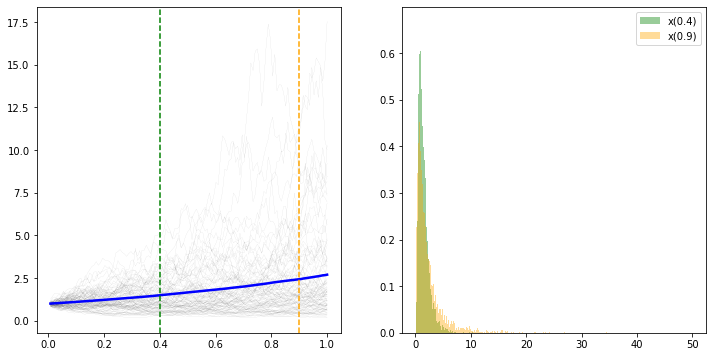

In [4]:
plot_paths()

In [5]:
def plot_discretisation(chosen_brownian_path_idx=0, R=5):   

    # EM Approximation - small dt
    x_em_small = np.zeros(N)
    x_em_small[0] = x0
    for j in range(1, N):
        x_em_small[j] = x_em_small[j - 1] + mu*x_em_small[j - 1]*dt + sigma*x_em_small[j - 1]*dB[chosen_brownian_path_idx, j-1]


    # EM Approximation - big dt
    coarse_grid = np.arange(0,1+dt,R*dt)
    x_em_big = np.zeros(coarse_grid.shape[0])
    x_em_big[0] = x0
    for j in range(coarse_grid.shape[0] - 1):
        x_em_big[j + 1] = x_em_big[j] + mu*x_em_big[j-1]*R*dt + sigma*x_em_big[j]*np.sum(dB[chosen_brownian_path_idx, int(R*j):int(R*(j+1))])

    x_mil_small = np.zeros(N)
    x_mil_small[0] = x0
    for j in range(1, N):
        x_mil_small[j] = x_mil_small[j - 1] + mu*x_mil_small[j - 1]*dt +  sigma * x_mil_small[j - 1] * dB[chosen_brownian_path_idx, j-1] + 0.5 * sigma**2 * x_mil_small[j - 1] * ((dB[chosen_brownian_path_idx, j-1])**2 - dt)


    fig, axes = plt.subplots(1, 2, figsize=(14, 7))   
    axes[0].plot(t, x[chosen_brownian_path_idx, :], label="Exact ($x_t$)", color='blue')
    axes[0].plot(t, x_em_small, label="EM ($\hat{x}_t$): Fine Grid", color='orange', ls='--')
    axes[0].plot(coarse_grid, x_em_big, label="EM ($\hat{x}_t$): Coarse Grid", color='green', ls='--')
    axes[0].set_title('E-M Approximation vs. Exact Simulation'); 
    axes[0].set_xlabel('t'); 
    axes[0].legend();


    axes[1].plot(t, x[chosen_brownian_path_idx, :], label="Exact ($x_t$)", color='blue', alpha=0.5)
    axes[1].plot(t, x_em_small, label="EM ($\hat{x}_t$): Fine Grid", color='orange', ls='--')
    axes[1].plot(t, x_mil_small, label="Milstein ($\hat{x}_t$): Fine Grid", color='green', ls='--')
    axes[1].set_title('E-M vs. Milstein')
    axes[1].set_xlabel('t') 
    axes[1].legend(loc = 2);
    
    plt.show()

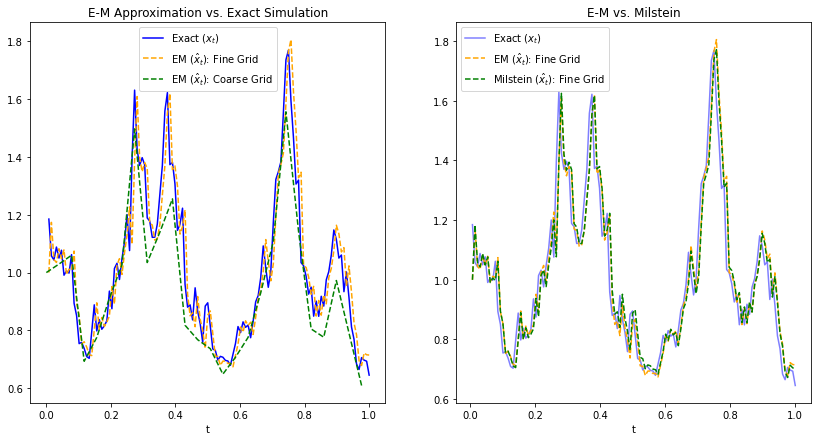

In [7]:
plot_discretisation(chosen_brownian_path_idx=5, R=5)

- Professor Des Higham has an [educational paper](https://doi.org/10.1109/MCSE.2004.62) on how to use Black Scholes SDE for option pricing.
- He also wrote a very accessible [paper](https://doi.org/10.1137/S0036144500378302) that discusses the simulation and the convergence of these two methods.

## Weak approximation of Ito-Taylor series

- Sometimes we are interested in the distributions of the paths, rather than paths themselves.
- Given that we only need to preserve the distribution, there is more freedom in forming approximation, mainly including stochastic integrals of higher order.
- As a result arbitrary order of convergence can be obtained in a tractable way (see chapter 14 of the Kloeden and Platen textbook)

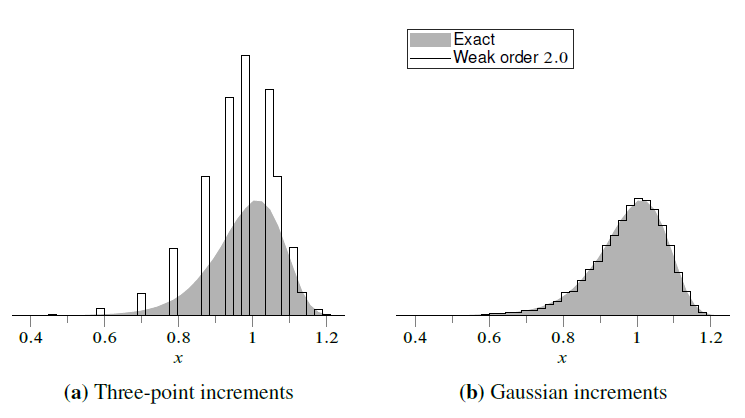

# Runge-Kutta methods

1. Motivation
2. Ordinary Runge-Kutta
3. Stochastic Runge-Kutta Methods

## Motivation

- Milstein method requires partial derivatives of $\mathbf{L}(\mathbf{x}(t), t)$ with respect to each of $x_i$'s.
- Other methods also requite partial derivatives of $\mathbf{L}(\mathbf{x}(t), t)$ with respect to each of $x_i$'s as well as $t$.

Runge-Kutta:
- subdivide the integration interval into intermediate steps
- evaluating the function $\mathbf{f}(\cdot, \cdot)$ at a number of points and weighting these evaluations

## Ordinary Runge-Kutta

Consider the following ODE:

$$
\frac{\mathrm{d} \mathbf{x}(t)}{\mathrm{d} t}=\mathbf{f}(\mathbf{x}(t), t), \quad \mathbf{x}\left(t_{0}\right)=\mathbf{x}_{0}
$$

and its Taylor expansion up to $(\Delta t)^2$
$$
\begin{align}
\mathbf{x}\left(t_{0}+\Delta t\right) &\approx \mathbf{x}\left(t_{0}\right)+\mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \Delta t \nonumber\\
 & \quad +\frac{1}{2}\left\{\frac{\partial}{\partial t} \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) +\sum_{i} f_{i}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \frac{\partial}{\partial x_{i}} \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \right\}(\Delta t)^2 .
\label{eq:rk-taylor-expand}
\end{align}
$$

The above has got derivatives, but we are seeking to replace the term involving the derivatives with expressions involving evaluations of $\mathbf{f}(\cdot, \cdot)$ at various points.

We are looking for something of the form:

$$
\begin{aligned}
\mathbf{x}\left(t_{0}+\Delta t\right) & \approx \mathbf{x}\left(t_{0}\right)+a \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \Delta t \\
 & \quad +b \mathbf{f}\left(\mathbf{x}\left(t_{0}\right)+c \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \Delta t, t_{0}+d \Delta t\right) \Delta t,
\end{aligned}
$$

where if we linearise the last term around $\mathbf{f}(\mathbf{x}(t_0), t_0)$ with the increments chosen as follows:

$$
\begin{array}{l}
\mathbf{f}\left(\mathbf{x}\left(t_{0}\right)+c \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \Delta t, t_{0}+d \Delta t\right) \approx \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \\
\quad+c\left(\sum_{i} f_{i}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \frac{\partial}{\partial x_{i}} \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)\right) \Delta t+d \frac{\partial \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)}{\partial t} \Delta t
\end{array}
$$



which gives

$$
\begin{array}{l}
\mathbf{x}\left(t_{0}+\Delta t\right) \approx \mathbf{x}\left(t_{0}\right)+(a+b) \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \Delta t \\
\quad+b\left\{c \sum_{i} f_{i}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right) \frac{\partial}{\partial x_{i}} \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)+d \frac{\partial \mathbf{f}\left(\mathbf{x}\left(t_{0}\right), t_{0}\right)}{\partial t}\right\}(\Delta t)^{2}
\end{array}
$$

and can be pattern matched with $\eqref{eq:rk-taylor-expand}$ to give 
$$
a = \frac{1}{2}, \quad b=\frac{1}{2}, \quad c = 1, \quad d = 1
$$

Coming up with these is an art form!

## The general explicit Runge-Kutta scheme

$$
\hat{\mathbf{x}}\left(t_{k+1}\right)=\hat{\mathbf{x}}\left(t_{k}\right)+\sum_{i=1}^{s} \alpha_{i} \mathbf{f}\left(\tilde{\mathbf{x}}_{i}, \tilde{t}_{i}\right) \Delta t,
$$
where $\tilde{t}_{i}=t_{k}+c_{i} \Delta t$ and $\tilde{\mathbf{x}}_{i}=\hat{\mathbf{x}}\left(t_{k}\right)+\sum_{j=1}^{s} A_{i, j} \mathbf{f}\left(\tilde{\mathbf{x}}_{j}, \tilde{t}_{j}\right) \Delta t$.


The corresponding Butcher's tableau is:
$$
\begin{array}{c|cccc}
c_{1} & A_{1,1} & & & \\
c_{2} & A_{2,1} & A_{2,2} & & \\
\vdots & \vdots & & \ddots & \\
c_{s} & A_{s, 1} & A_{s, 2} & \ldots & A_{s, s} \\
\hline & \alpha_{1} & \alpha_{2} & \ldots & \alpha_{s}
\end{array}
$$

### Fourth-order Runge-Kutta

$$
\begin{aligned}
\Delta \mathbf{x}_{k}^{1} &=\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right), t_{k} + \color{blue}{0}\Delta t\right) \Delta t \\
\Delta \mathbf{x}_{k}^{2} &=\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right)+\Delta  \color{green}{\frac{1}{2}}\mathbf{x}_{k}^{1}, t_{k}+ \color{blue}{\frac{1}{2}}\Delta t \right) \Delta t \\
\Delta \mathbf{x}_{k}^{3} &=\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right)+\Delta  \color{green}{\frac{1}{2}} \mathbf{x}_{k}^{2}, t_{k}+ \color{blue}{\frac{1}{2}}\Delta t \right) \Delta t \\
\Delta \mathbf{x}_{k}^{4} &=\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right)+ \color{green}{1}\Delta \mathbf{x}_{k}^{3}, t_{k}+ \color{blue}{1}\Delta t\right) \Delta t
\end{aligned}
$$

$$
\hat{\mathbf{x}}\left(t_{k+1}\right)=\hat{\mathbf{x}}\left(t_{k}\right)+\color{red}{\frac{1}{6}}\Delta \mathbf{x}_{k}^{1}+ \color{red}{\frac{1}{3}} \Delta \mathbf{x}_{k}^{2}+ \color{red}{\frac{1}{3}} \Delta \mathbf{x}_{k}^{3}+ \color{red}{\frac{1}{6}} \Delta \mathbf{x}_{k}^{4}
$$

The corresponding Butcher's tableau is
$$
\begin{array}{c|cccc}
\color{blue}{0} & & & & \\
\color{blue}{\frac{1}{2}} & \color{green}{\frac{1}{2}} & & & \\
\color{blue}{\frac{1}{2}} & 0 & \color{green}{\frac{1}{2}} & & \\
\color{blue}{1} & 0 & 0 & \color{green}{1} & \\
\hline & \color{red}{\frac{1}{6}} & \color{red}{\frac{1}{3}} & \color{red}{\frac{1}{3}} & \color{red}{\frac{1}{6}}
\end{array}
$$




## Stochastic Runge-Kutta


$$
\begin{array}{c|c|c|c}
\mathbf{c}^{(0)} & \mathbf{A}^{(0)} & \mathbf{B}^{(0)} & \\
\hline \mathbf{c}^{(1)} & \mathbf{A}^{(1)} & \mathbf{B}^{(1)} & \\
\hline & \alpha^{\top} & {\left[\gamma^{(1)}\right]^{\top}} & {\left[\gamma^{(2)}\right]^{\top}}
\end{array}
$$
On each step $k$, approximate the solution trajectory as follows:
$\hat{\mathbf{x}}\left(t_{k+1}\right)=\hat{\mathbf{x}}\left(t_{k}\right)+\sum_{i} \alpha_{i} \mathbf{f}\left(\tilde{\mathbf{x}}_{i}^{(0)}, t_{k}+c_{i}^{(0)} \Delta t\right) \Delta t$
$$
+\sum_{i, n}\left(\gamma_{i}^{(1)} \Delta \beta_{k}^{(n)}+\gamma_{i}^{(2)} \sqrt{\Delta t}\right) \mathbf{L}_{n}\left(\tilde{\mathbf{x}}_{i}^{(n)}, t_{k}+c_{i}^{(1)} \Delta t\right)
$$
with the supporting values
$$
\begin{aligned}
\tilde{\mathbf{x}}_{i}^{(0)}=\hat{\mathbf{x}}\left(t_{k}\right) &+\sum_{j} A_{i, j}^{(0)} \mathbf{f}\left(\tilde{\mathbf{x}}_{j}^{(0)}, t_{k}+c_{j}^{(0)} \Delta t\right) \Delta t \\
&+\sum_{j, l} B_{i, j}^{(0)} \mathbf{L}_{l}\left(\tilde{\mathbf{x}}_{j}^{(l)}, t_{k}+c_{j}^{(1)} \Delta t\right) \Delta \beta_{k}^{(l)} \\
\tilde{\mathbf{x}}_{i}^{(n)}=\hat{\mathbf{x}}\left(t_{k}\right) &+\sum_{j} A_{i, j}^{(1)} \mathbf{f}\left(\tilde{\mathbf{x}}_{j}^{(0)}, t_{k}+c_{j}^{(0)} \Delta t\right) \Delta t \\
&+\sum_{j, l} B_{i, j}^{(1)} \mathbf{L}_{l}\left(\tilde{\mathbf{x}}_{j}^{(l)}, t_{k}+c_{j}^{(1)} \Delta t\right) \frac{\Delta \chi_{k}^{(l, n)}}{\sqrt{\Delta t}}
\end{aligned}
$$
for $i=1,2, \ldots, s$ and $n=1,2, \ldots, S$.
The increments in Algorithm 8.12 are given by the Itô integrals:
$$
\begin{aligned}
\Delta \beta_{k}^{(i)} &=\int_{t_{k}}^{t_{k+1}} \mathrm{~d} \beta_{i}(\tau) \text { and } \\
\Delta \chi_{k}^{(i, j)} &=\int_{t_{k}}^{t_{k+1}} \int_{t_{k}}^{\tau_{2}} \mathrm{~d} \beta_{i}\left(\tau_{1}\right) \mathrm{d} \beta_{j}\left(\tau_{2}\right),
\end{aligned}
$$
for $i, j=1,2, \ldots, S .$ The increments $\Delta \beta_{k}^{(i)}$ are normally distributed random variables such that jointly $\Delta \boldsymbol{\beta}_{k} \sim \mathrm{N}(\boldsymbol{0}, \mathbf{Q} \Delta t)$. The iterated stochastic Itô integrals $\Delta \chi_{k}^{(i, j)}$ are trickier. For these methods, when $i=j$ the multiple Itô integrals can be rewritten as
$$
\Delta \chi_{k}^{(i, i)}=\frac{1}{2}\left(\left[\Delta \beta_{k}^{(i)}\right]^{2}-Q_{i, i} \Delta t\right)
$$

## Weak Runge-Kutta

- the idea is the same -- if we are interested only in the distribution, the stochastic double integrals terms can be made tractable, thus allowing inclusion of higher-order terms.

# Verlet Algorithm

- Solving 2nd order stochastic SDEs
- Considering central difference

Example:
$$
\ddot{x}=f(x)-\eta b^{2}(x) \dot{x}+b(x) w(t),
$$
which can be rewritten into
$$
\begin{array}{l}
\mathrm{d} x(t)=\mathrm{d} v(t) \mathrm{d} t \\
\mathrm{~d} v(t)=-\eta b^{2}(x(t)) v(t) \mathrm{d} t+f(x(t)) \mathrm{d} t+b(x(t)) \mathrm{d} \beta(t) .
\end{array}
$$

### Leapfrog Verlet Algorithm

1. $\Delta \beta_{k} \sim \mathrm{N}(0, q \Delta t)$
2. $\tilde{x}=\hat{x}\left(t_{k}\right)+\frac{1}{2} v\left(t_{k}\right) \Delta t$
3. 
$$
\begin{array}{l}
\hat{v}\left(t_{k+1}\right)=\hat{v}\left(t_{k}\right)-\eta b^{2}(\tilde{x}) \hat{v}\left(t_{k}\right) \Delta t+f(\tilde{x}) \Delta t+b(\tilde{x}) \Delta \beta_{k} \\
\hat{x}\left(t_{k+1}\right)=\tilde{x}+\frac{1}{2} \hat{v}\left(t_{k+1}\right) \Delta t
\end{array}
$$

As many evaluations as E-M but often performs better; time-reversible;

# Exact Algorithm

- Based on rejection sampling, where the sampled distribution is the Brownian motion
- From Girsanov theorem, we can compute the likelihood ratio between the process $\mathbf{x}$ and the Brownian motion, using Radon-Nikodym derivative
$$
\frac{\mathrm{d} P_{\mathbf{x}}}{\mathrm{d} P_{\boldsymbol{\beta}}}=\exp \left(\psi(\boldsymbol{\beta}(T))-\psi(\boldsymbol{\beta}(0))-\frac{1}{2} \int_{0}^{T}\left[\|\mathbf{f}(\boldsymbol{\beta})\|^{2}+(\nabla \cdot \mathbf{f}(\boldsymbol{\beta}))\right] \mathrm{d} t\right),
$$
where $\mathbf{f}(\mathbf{x}) = \nabla \psi (\mathbf{x})$.

By considering biased Brownian motion whose final point has density as

$$
h(\tilde{\boldsymbol{\beta}}(T)) \propto \exp \left(\psi(\tilde{\boldsymbol{\beta}}(T))-\frac{1}{2 T}\|\tilde{\boldsymbol{\beta}}(T)\|^{2}\right)
$$

we have 

$$
\frac{\mathrm{d} P_{\mathbf{x}}}{\mathrm{d} P_{\tilde{\beta}}} \propto \exp \left(-\int_{0}^{T} \phi(\boldsymbol{\beta}) \mathrm{d} t\right) \leq 1,
$$

where
$$
\phi(\boldsymbol{\beta})=\frac{1}{2}\left[\|\mathbf{f}(\boldsymbol{\beta})\|^{2}+(\nabla \cdot \mathbf{f}(\boldsymbol{\beta}))\right]-c
$$
and we also assume that $\phi(\boldsymbol{\beta}) < M$

If all of the $x_i$'s lie above corresponding $\phi(\tilde{\beta}(t_i))$, then fill in with Brownian bridges between the points and accept.
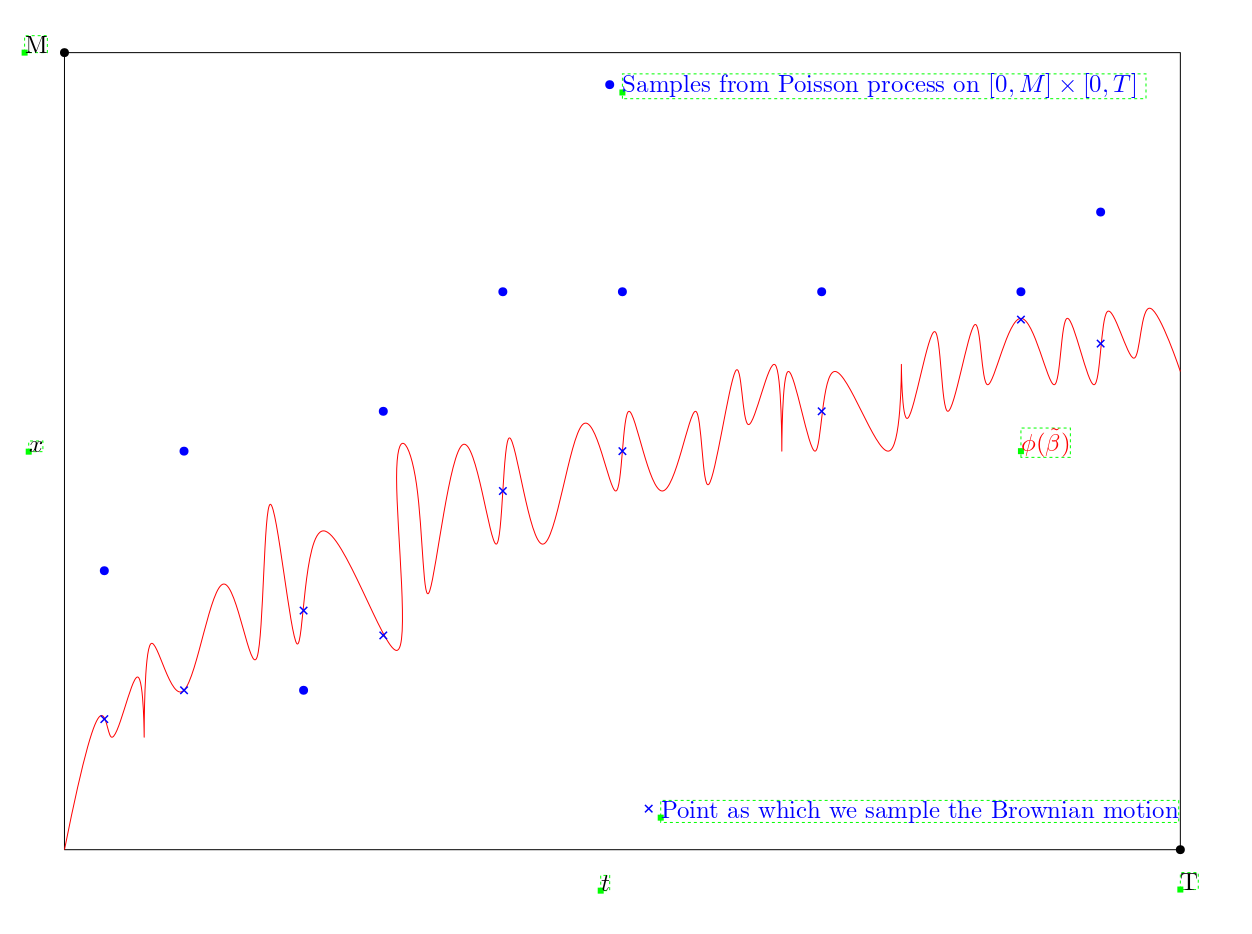

### Black-scholes

- the more volatile the returns, the more valuable the option is

# References

- Applied Stochastic Differential Equations by Särkkä and Solin, CUP  2019
- [A blogpost on simulating SDEs in Python by Hautahi Kingi](https://hautahi.com/sde_simulation)